In [1]:
import pandas as pd
import os
import json


In [2]:
business_json_path = 'business.json'
business = pd.read_json(business_json_path, lines=True)
business.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
filtered_business = business[business['categories'].str.contains('Breakfast & Brunch', na=False) &
                             business['categories'].str.contains('Restaurants', na=False) &
                             (business['city'] == 'Indianapolis')& 
                             (business['state'] == 'IN')]



In [4]:
len(filtered_business)

337

In [5]:
business_ids = set(filtered_business['business_id'])


filtered_reviews = []


review_json_path = 'review.json'
chunk_size = 100000  
for chunk in pd.read_json(review_json_path, lines=True, chunksize=chunk_size):
    
    filtered_chunk = chunk[chunk['business_id'].isin(business_ids)]
    filtered_reviews.append(filtered_chunk)


all_filtered_reviews = pd.concat(filtered_reviews, ignore_index=True)


merged_data = pd.merge(filtered_business, all_filtered_reviews, on='business_id')

merged_data1=pd.merge(filtered_business, all_filtered_reviews, on='business_id')

merged_data2=pd.merge(filtered_business, all_filtered_reviews, on='business_id')

In [6]:
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk.download('wordnet')
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Patron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Patron/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Patron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def clean_text(text):
    text = text.lower() # covert to lower cases
    text = [word.strip(string.punctuation) for word in text.split(" ")]# tokenize text and remove puncutation
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]#remove stopwords
    text = [t for t in text if len(t) > 1]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]#lemmatize
    text = " ".join(text)
    return(text)

# add this clean reviews column to the dataset
merged_data['clean_reviews'] = merged_data['text'].apply(lambda x: clean_text(x))

In [16]:
import pandas as pd
import re

def extract_snippets(text, keyword, window_size=15):
    snippets = []
    for review, rating in zip(text, merged_data["stars_x"]):
        matches = re.finditer(r'\b{}\b'.format(re.escape(keyword)), review, re.IGNORECASE)
        for match in matches:
            start = max(0, match.start() - window_size)
            end = min(len(review), match.end() + window_size)
            snippet = review[start:end].strip()
            snippets.append({"snippet": snippet, "rating": rating})
    return snippets

def find_and_analyze_breakfast_foods(text):
    breakfast_foods = ["Pancakes", 'Waffles', 'French Toast', 'Eggs Benedict', 'Omelette',
        'Scrambled Eggs', 'Poached Eggs', 'Fried Eggs', 'Boiled Eggs', 'Turkey Bacon',
        'Breakfast Burrito', 'Breakfast Tacos', 'Bagels', 'Toast', 'Avocado Toast',
        'Granola', 'Yogurt Parfait', 'Fruit Salad', 'Smoothie Bowl', 'Acai Bowl',
        'Porridge', 'Oatmeal', 'Grits', 'Corned Beef Hash', 'Biscuits and Gravy',
        'Huevos Rancheros', 'Bacon',' Ham', 'Sausage', 'Fried Chicken',
        'Fries', 'Hash Browns', 'Breakfast Sandwich', 'Croissant', 'Danish',
        'Cinnamon Rolls', 'Scones', 'Muffins', 'Coffee Cake', 'Crepes']


    food_snippets = {}

    for food in breakfast_foods:
        snippets = extract_snippets(text, food)
        food_snippets[food] = snippets

    return food_snippets

def analyze_and_aggregate(food_snippets):
    aggregated_data = {"Food": [], "Average Rating": [], "Mentions": []}

    for food, snippets in food_snippets.items():
        ratings = [snippet["rating"] for snippet in snippets]
        mentions = len(snippets)
        average_rating = sum(ratings) / len(ratings) if len(ratings) > 0 else 0

        aggregated_data["Food"].append(food)
        aggregated_data["Average Rating"].append(average_rating)
        aggregated_data["Mentions"].append(mentions)

    return pd.DataFrame(aggregated_data)

# Find and analyze breakfast foods in the text column
food_snippets = find_and_analyze_breakfast_foods(merged_data["text"])

# Analyze and aggregate the data
aggregated_data = analyze_and_aggregate(food_snippets)

# Print the aggregated data
aggregated_data.head()


,Food,Average Rating,Mentions
0,Pancakes,3.906671,3118
1,Waffles,4.031821,1587
2,French Toast,4.022227,2317
3,Eggs Benedict,4.063704,675
4,Omelette,4.026428,1646


In [23]:
food_snippets1 = find_and_analyze_breakfast_foods(merged_data["clean_reviews"])

# Analyze and aggregate the data
aggregated_data1 = analyze_and_aggregate(food_snippets)

# Print the aggregated data
aggregated_data1.head()

,Food,Average Rating,Mentions
0,Pancakes,3.906671,3118
1,Waffles,4.031821,1587
2,French Toast,4.022227,2317
3,Eggs Benedict,4.063704,675
4,Omelette,4.026428,1646


In [24]:
aggregated_data1

,Food,Average Rating,Mentions
0,Pancakes,3.906671,3118
1,Waffles,4.031821,1587
2,French Toast,4.022227,2317
3,Eggs Benedict,4.063704,675
4,Omelette,4.026428,1646
5,Scrambled Eggs,3.907455,389
6,Poached Eggs,4.084906,159
7,Fried Eggs,3.984848,33
8,Boiled Eggs,3.900000,25
9,Turkey Bacon,3.683333,60


In [25]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import re

# Assuming 'merged_data' is your DataFrame and it contains a column 'clean_reviews'
# Also assuming 'food_items' is your list of food items as defined in your original code

def aggregate_food_sentiments(reviews, food_items):
    all_food_sentiments = {food.lower(): [] for food in food_items}  # Aggregate sentiments

    for review in reviews:
        sentences = [sentence for sentence in TextBlob(review).sentences]
        for sentence in sentences:
            sentence_text = str(sentence).lower()
            for food in all_food_sentiments:
                if re.search(r'\b' + re.escape(food) + r'\b', sentence_text):
                    sentiment = sentence.sentiment.polarity
                    all_food_sentiments[food].append(sentiment)

    return all_food_sentiments

# Aggregate sentiments across all reviews
all_reviews = merged_data['clean_reviews']
aggregated_sentiments = aggregate_food_sentiments(all_reviews, food_items)

# Calculate average sentiment for each food item
average_sentiments = {food: np.mean(sentiments) if sentiments else np.nan for food, sentiments in aggregated_sentiments.items()}

# Convert to DataFrame for better visualization
average_sentiments_df = pd.DataFrame(list(average_sentiments.items()), columns=['Food', 'Average Sentiment'])

# Print or view the DataFrame
print(average_sentiments_df)


                  Food  Average Sentiment
0             pancakes           0.267840
1              waffles           0.115245
2         french toast           0.249618
3        eggs benedict           0.293596
4             omelette           0.281152
5       scrambled eggs           0.307143
6         poached eggs                NaN
7           fried eggs                NaN
8          boiled eggs                NaN
9         turkey bacon           0.216606
10   breakfast burrito           0.300887
11     breakfast tacos           0.303472
12              bagels           0.154055
13               toast           0.263919
14       avocado toast           0.332131
15             granola           0.280868
16      yogurt parfait           0.364693
17         fruit salad           0.235528
18       smoothie bowl           0.172063
19           acai bowl           0.278940
20            porridge           0.299238
21             oatmeal           0.268660
22               grits           0

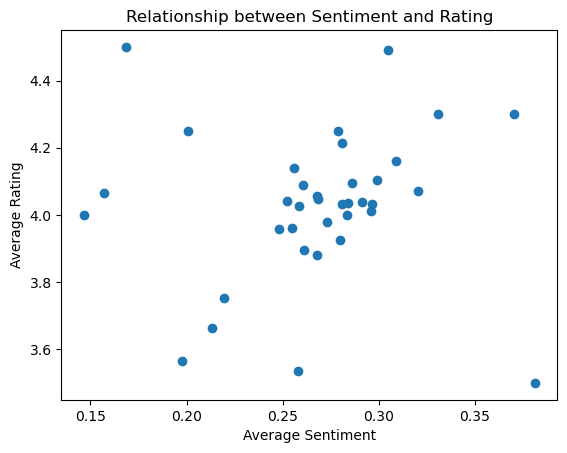

Correlation coefficient: 0.06434495709757594


In [26]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import re

# Assuming 'merged_data' is your DataFrame with columns 'clean_reviews' and 'stars-x'

def calculate_review_sentiment(review):
    return TextBlob(review).sentiment.polarity

# Calculate sentiment for each review
merged_data['review_sentiment'] = merged_data['clean_reviews'].apply(calculate_review_sentiment)

# Function to identify which food items are mentioned in each review
def identify_food_items_in_review(review, food_items):
    mentioned_items = []
    for food in food_items:
        if re.search(r'\b' + re.escape(food.lower()) + r'\b', review.lower()):
            mentioned_items.append(food)
    return mentioned_items

# Identify mentioned food items in each review
merged_data['mentioned_food_items'] = merged_data['clean_reviews'].apply(lambda x: identify_food_items_in_review(x, food_items))

# Expand this DataFrame so each row contains one food item mention and the corresponding review sentiment and rating
expanded_data = merged_data.explode('mentioned_food_items')

# Group by food item and calculate the average sentiment and rating
grouped_data = expanded_data.groupby('mentioned_food_items').agg({'review_sentiment': 'mean', 'stars_x': 'mean'}).reset_index()

# Statistical Analysis: Calculate the correlation between sentiment and rating
correlation = grouped_data['review_sentiment'].corr(grouped_data['stars_x'])

# Visualization
import matplotlib.pyplot as plt

plt.scatter(grouped_data['review_sentiment'], grouped_data['stars_x'])
plt.xlabel('Average Sentiment')
plt.ylabel('Average Rating')
plt.title('Relationship between Sentiment and Rating')
plt.show()

print("Correlation coefficient:", correlation)


In [32]:
from transformers import pipeline, AutoTokenizer
import pandas as pd
import re

# Initialize the sentiment-analysis pipeline and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def truncate(tokens, max_length):
    # Truncate the tokens to a length that the model can handle
    return tokens[:max_length]

def food_item_sentiment(review, food_items, context_window=50):
    sentiments = []
    sentences = re.split(r'(?<=[.!?]) +', review)

    for sentence in sentences:
        for food in food_items:
            food_lower = food.lower()
            if food_lower in sentence.lower():
                # Find the position of the food item in the sentence
                start_index = sentence.lower().find(food_lower)
                end_index = start_index + len(food_lower)

                # Extract a window of text around the food item
                window_start = max(0, start_index - context_window)
                window_end = min(len(sentence), end_index + context_window)
                text_window = sentence[window_start:window_end]

                # Tokenize and truncate
                tokens = tokenizer.tokenize(text_window)
                tokens = truncate(tokens, tokenizer.model_max_length - 2)  # Reserve space for special tokens
                truncated_text = tokenizer.convert_tokens_to_string(tokens)

                # Sentiment analysis
                result = sentiment_pipeline(truncated_text)[0]
                sentiments.append((food, result['label'], result['score']))
                break  # Stop after finding the first food item

    return sentiments

# Apply the function
merged_data['food_sentiments'] = merged_data['clean_reviews'].apply(lambda x: food_item_sentiment(x, food_items, context_window=50))

# Example of output
print(merged_data['food_sentiments'].head())


0                                        []
1                                        []
2                                        []
3                                        []
4    [( Ham, NEGATIVE, 0.9993378520011902)]
Name: food_sentiments, dtype: object


In [90]:
# Flatten the list of sentiments with index
flat_sentiments_with_index = [(index, food, sentiment, score) for index, sentiment_list in enumerate(merged_data['food_sentiments']) for food, sentiment, score in sentiment_list if sentiment_list]

# Create a DataFrame from the flat list
sentiments_with_index_df = pd.DataFrame(flat_sentiments_with_index, columns=['Index', 'Food', 'Sentiment', 'Score'])

# Merge with the original DataFrame to get the corresponding ratings
merged_sentiments_ratings = pd.merge(sentiments_with_index_df, merged_data[['stars_x']], left_on='Index', right_index=True)

print(merged_sentiments_ratings.head())

# Group by food and sentiment, then calculate the mean rating
average_ratings = merged_sentiments_ratings.groupby(['Food', 'Sentiment'])['stars_x'].mean().reset_index()

# Merge with the sentiment counts
sentiment_counts_df = pd.DataFrame(sentiment_counts.items(), columns=['Food_Sentiment', 'Count'])
sentiment_counts_df[['Food', 'Sentiment']] = pd.DataFrame(sentiment_counts_df['Food_Sentiment'].tolist(), index=sentiment_counts_df.index)
sentiment_counts_df.drop('Food_Sentiment', axis=1, inplace=True)

final_df = pd.merge(sentiment_counts_df, average_ratings, on=['Food', 'Sentiment'])

print(final_df)




   Index          Food Sentiment     Score  stars_x
0      4           Ham  NEGATIVE  0.999338      2.5
1      6         Bacon  NEGATIVE  0.999638      2.5
2      8  French Toast  NEGATIVE  0.942141      2.5
3     13  French Toast  NEGATIVE  0.999308      2.5
4     14      Omelette  POSITIVE  0.998769      2.5
    Count            Food Sentiment   stars_x
0     259             Ham  NEGATIVE  3.853282
1    1004           Bacon  NEGATIVE  3.880976
2     642    French Toast  NEGATIVE  3.978193
3     751        Omelette  POSITIVE  4.062583
4     935           Toast  POSITIVE  4.150802
..    ...             ...       ...       ...
60      7       Acai Bowl  NEGATIVE  4.571429
61     21       Acai Bowl  POSITIVE  4.476190
62      2  Cinnamon Rolls  POSITIVE  4.250000
63      2     Hash Browns  NEGATIVE  3.750000
64      3          Crepes  NEGATIVE  4.500000

[65 rows x 4 columns]


In [91]:
# Format the average ratings to two decimal places
final_df['Average Rating'] = final_df['stars_x'].round(2)

# Select and rename columns for clearer presentation
formatted_df = final_df[['Food', 'Sentiment', 'Count', 'Average Rating']]

# Sort the DataFrame for better readability (optional)
formatted_df = formatted_df.sort_values(['Food', 'Sentiment'])

# Print the formatted DataFrame
print(formatted_df.to_string(index=False))


              Food Sentiment  Count  Average Rating
               Ham  NEGATIVE    259            3.85
               Ham  POSITIVE    197            4.03
         Acai Bowl  NEGATIVE      7            4.57
         Acai Bowl  POSITIVE     21            4.48
             Bacon  NEGATIVE   1004            3.88
             Bacon  POSITIVE    904            3.98
            Bagels  NEGATIVE     15            3.63
            Bagels  POSITIVE     12            3.46
 Breakfast Burrito  NEGATIVE     89            3.89
 Breakfast Burrito  POSITIVE    148            4.08
Breakfast Sandwich  NEGATIVE     82            3.94
Breakfast Sandwich  POSITIVE    129            4.04
   Breakfast Tacos  NEGATIVE      5            3.60
   Breakfast Tacos  POSITIVE     14            4.25
    Cinnamon Rolls  POSITIVE      2            4.25
       Coffee Cake  NEGATIVE     12            3.88
       Coffee Cake  POSITIVE     16            4.22
  Corned Beef Hash  NEGATIVE      7            4.07
  Corned Bee

In [92]:
import pandas as pd


# Group by sentiment and calculate the mean of the average ratings
average_ratings_by_sentiment = formatted_df.groupby('Sentiment')['Average Rating'].mean()

# This will give you a Series with the average of average ratings for each sentiment
print(average_ratings_by_sentiment)


Sentiment
NEGATIVE    3.964375
POSITIVE    4.046667
Name: Average Rating, dtype: float64


In [66]:
df1 = pd.DataFrame(formatted_df)

# Convert Sentiment to numeric
df1['Sentiment'] = df1['Sentiment'].map({'NEGATIVE': -1, 'POSITIVE': 1})

# Calculate the correlation matrix
correlation_matrix = df1[['Sentiment', 'Average Rating']].corr()

print("Correlation between Sentiment and Average Rating:")
print(correlation_matrix)

#although statistcally the correlation is slow you can see that sentiment changing does have an effect, it could be due to othe rfcators but in the resrtaunt business food does matter so a gneral recommedation would be to focus on foods that have been heavily reviewed, going throgh the text review and organzaing things into topics you can see that foods were reviewed more than anything else. 

Correlation between Sentiment and Average Rating:
                Sentiment  Average Rating
Sentiment        1.000000        0.185323
Average Rating   0.185323        1.000000


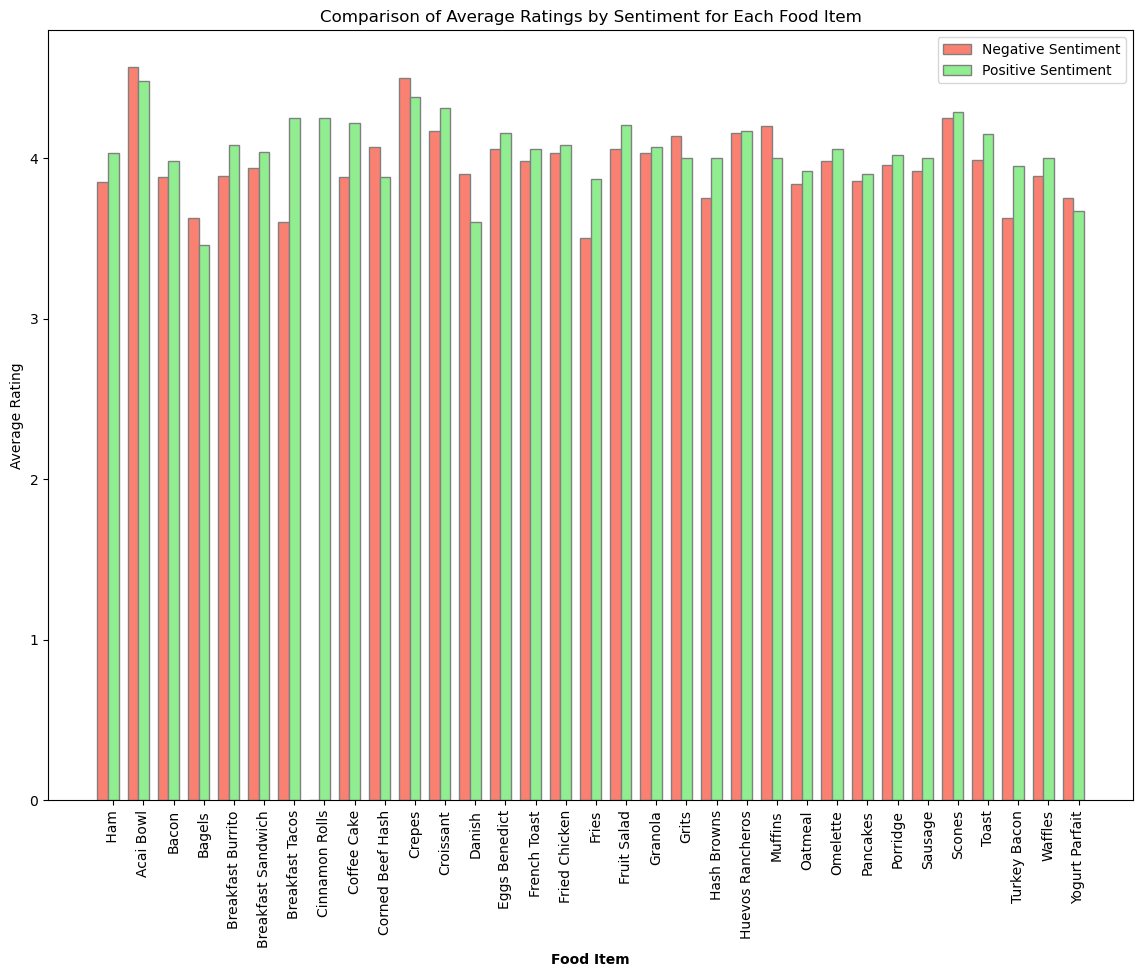

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df=formatted_df


# Pivot to get the average ratings for each sentiment per food item
pivot_df = df.pivot_table(index='Food', columns='Sentiment', values='Average Rating').fillna(0)

# Reset index to make 'Food' a column again for easy plotting
pivot_df.reset_index(inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))

# Set the width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(pivot_df))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, pivot_df['NEGATIVE'], color='salmon', width=bar_width, edgecolor='grey', label='Negative Sentiment')
ax.bar(r2, pivot_df['POSITIVE'], color='lightgreen', width=bar_width, edgecolor='grey', label='Positive Sentiment')

# Add xticks on the middle of the group bars
ax.set_xlabel('Food Item', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(r1))])
ax.set_xticklabels(pivot_df['Food'], rotation=90)
ax.set_ylabel('Average Rating')
ax.set_title('Comparison of Average Ratings by Sentiment for Each Food Item')

# Create legend & Show graphic
ax.legend()
plt.show()


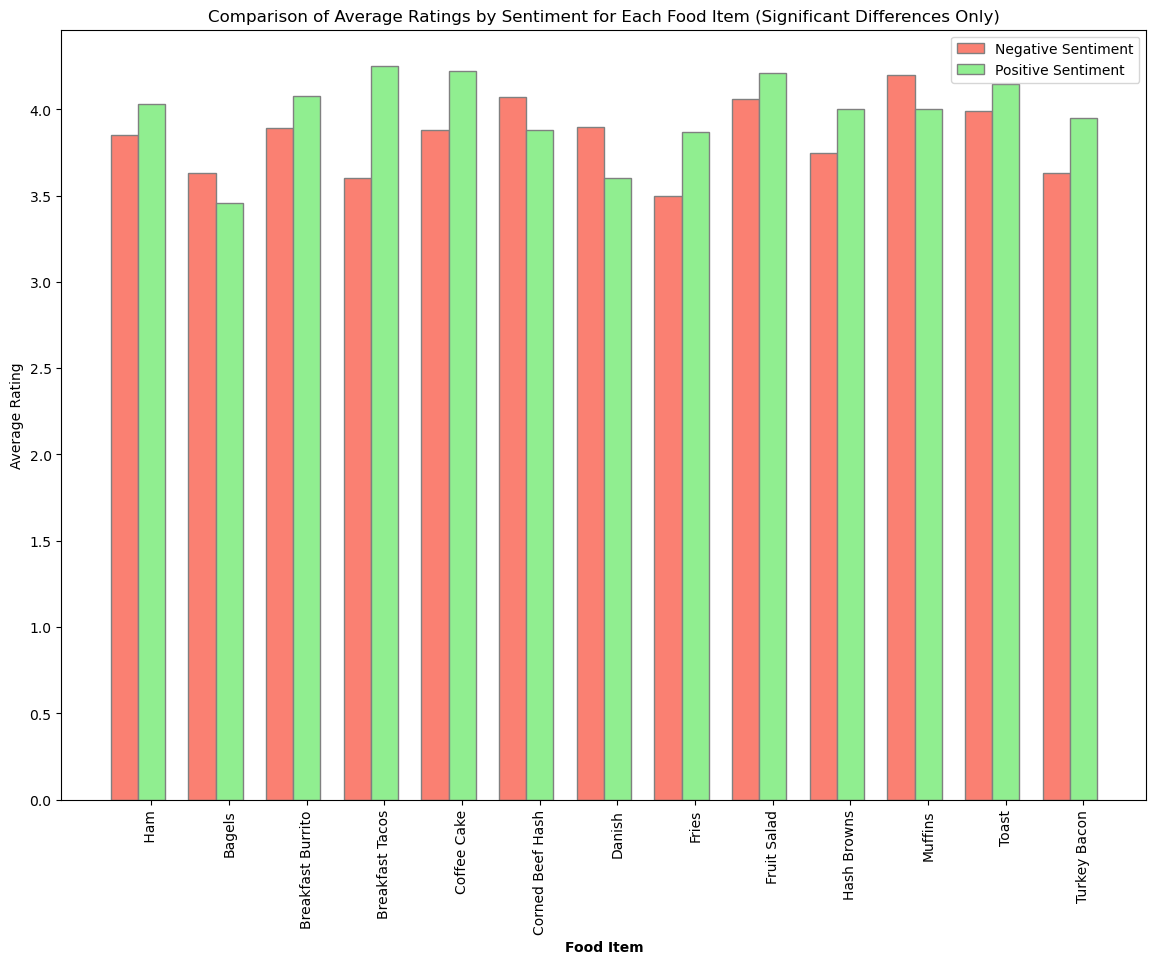

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'formatted_df' is your DataFrame with the data

# Calculate the difference in average rating between positive and negative sentiments
formatted_df['Rating Difference'] = formatted_df.groupby('Food')['Average Rating'].transform(lambda x: x.max() - x.min())

# Filter out foods where the difference in rating is below the threshold (e.g., 0.1)
significant_diff_df = formatted_df[formatted_df['Rating Difference'] >= 0.15]

# Pivot the data to have separate columns for negative and positive average ratings
pivot_df = significant_diff_df.pivot(index='Food', columns='Sentiment', values='Average Rating').fillna(0)

# Now create the bar plot, showing only foods with significant rating differences
fig, ax = plt.subplots(figsize=(14, 10))

# Set the width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(pivot_df))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, pivot_df['NEGATIVE'], color='salmon', width=bar_width, edgecolor='grey', label='Negative Sentiment')
ax.bar(r2, pivot_df['POSITIVE'], color='lightgreen', width=bar_width, edgecolor='grey', label='Positive Sentiment')

# Add xticks on the middle of the group bars
ax.set_xlabel('Food Item', fontweight='bold')
ax.set_xticks([r + bar_width for r in range(len(r1))])
ax.set_xticklabels(pivot_df.index, rotation=90)
ax.set_ylabel('Average Rating')
ax.set_title('Comparison of Average Ratings by Sentiment for Each Food Item (Significant Differences Only)')

# Create legend & Show graphic
ax.legend()
plt.show()


#maybe by counts??


In [135]:
pivot_df = pivot_df.reset_index()
x=pivot_df.drop(pivot_df.columns[0], axis=1, inplace=True)


In [133]:
x

In [129]:
# Assuming combined_data is your DataFrame

# Store the DataFrame as a CSV file
pivot_df.to_csv('pivot_df', index=False)  # Specify the filename and set index to False to exclude the index column

# Provide a link to download the CSV file
from IPython.display import FileLink
FileLink('pivot_df.csv')

/Users/Patron/Desktop/untitled folder/Yelp /pivot_df.csv

In [123]:
import os
file_path = 'pivot_df.csv'  # Replace with the actual file path
print(os.path.abspath(file_path))


/Users/Patron/Desktop/untitled folder/Yelp /pivot_df.csv


In [36]:
# Flatten the list of sentiments
flat_sentiments = [(food, sentiment, score) for sentiment_list in merged_data['food_sentiments'] for food, sentiment, score in sentiment_list if sentiment_list]
from collections import Counter

# Count occurrences
sentiment_counts = Counter((food, sentiment) for food, sentiment, score in flat_sentiments)

# Convert to DataFrame for easier analysis
sentiment_df = pd.DataFrame(sentiment_counts.items(), columns=['Food_Sentiment', 'Count'])
sentiment_df[['Food', 'Sentiment']] = pd.DataFrame(sentiment_df['Food_Sentiment'].tolist(), index=sentiment_df.index)
sentiment_df.drop('Food_Sentiment', axis=1, inplace=True)

print(sentiment_df.head())



   Count          Food Sentiment
0    259           Ham  NEGATIVE
1   1004         Bacon  NEGATIVE
2    642  French Toast  NEGATIVE
3    751      Omelette  POSITIVE
4    935         Toast  POSITIVE


In [45]:
sentiment_df

,Count,Food,Sentiment
0,259,Ham,NEGATIVE
1,1004,Bacon,NEGATIVE
2,642,French Toast,NEGATIVE
3,751,Omelette,POSITIVE
4,935,Toast,POSITIVE
...,...,...,...
60,7,Acai Bowl,NEGATIVE
61,21,Acai Bowl,POSITIVE
62,2,Cinnamon Rolls,POSITIVE
63,2,Hash Browns,NEGATIVE


In [39]:
 # Create a DataFrame from the flat list
sentiment_details_df = pd.DataFrame(flat_sentiments, columns=['Food', 'Sentiment', 'Score'])

# Group by food and calculate mean score
average_scores = sentiment_details_df.groupby('Food')['Score'].mean()
print(average_scores.head())


Food
 Ham                 0.946780
Acai Bowl            0.986194
Bacon                0.948177
Bagels               0.939092
Breakfast Burrito    0.956521
Name: Score, dtype: float64


In [41]:
average_scores

Food
 Ham                  0.946780
Acai Bowl             0.986194
Bacon                 0.948177
Bagels                0.939092
Breakfast Burrito     0.956521
Breakfast Sandwich    0.944692
Breakfast Tacos       0.919027
Cinnamon Rolls        0.983739
Coffee Cake           0.933234
Corned Beef Hash      0.937291
Crepes                0.952375
Croissant             0.952068
Danish                0.981476
Eggs Benedict         0.966583
French Toast          0.950977
Fried Chicken         0.936761
Fries                 0.972048
Fruit Salad           0.966093
Granola               0.950278
Grits                 0.952128
Hash Browns           0.989954
Huevos Rancheros      0.946982
Muffins               0.946165
Oatmeal               0.945035
Omelette              0.954880
Pancakes              0.939646
Porridge              0.927779
Sausage               0.938597
Scones                0.956199
Toast                 0.953591
Turkey Bacon          0.950595
Waffles               0.962552
Yog

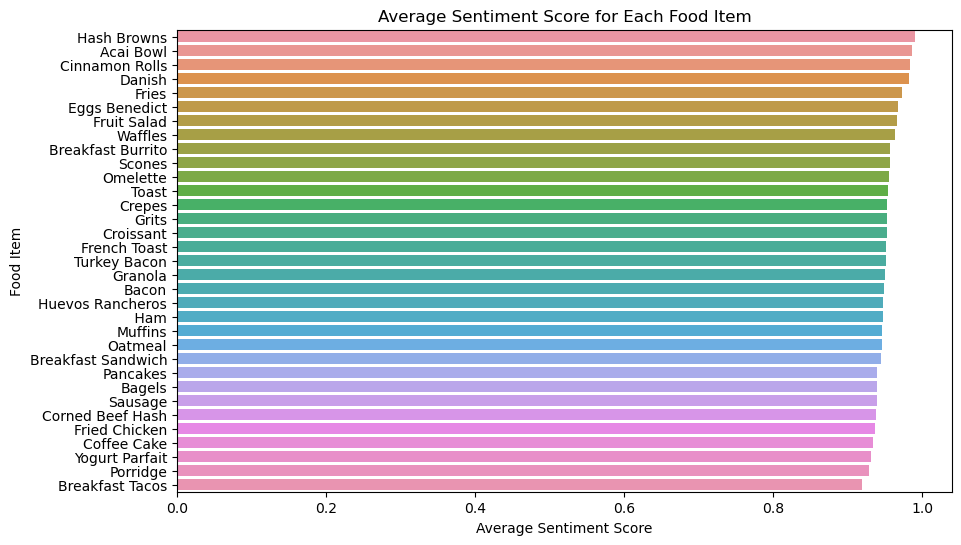

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort for better visualization
average_scores_sorted = average_scores.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=average_scores_sorted.values, y=average_scores_sorted.index)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Food Item')
plt.title('Average Sentiment Score for Each Food Item')
plt.show()
